In [398]:
#importing libraries
import numpy as np 
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor

In [399]:
df = pd.read_csv("https://raw.githubusercontent.com/Ozodiy/Aviaticket_price_predictor/main/train_data.csv")
df.head()

,id,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


### Learing data

In [400]:
#informations about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                20000 non-null  int64  
 1   airline           20000 non-null  object 
 2   flight            20000 non-null  object 
 3   source_city       20000 non-null  object 
 4   departure_time    20000 non-null  object 
 5   stops             20000 non-null  object 
 6   arrival_time      20000 non-null  object 
 7   destination_city  20000 non-null  object 
 8   class             20000 non-null  object 
 9   duration          20000 non-null  float64
 10  days_left         20000 non-null  int64  
 11  price             20000 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 1.8+ MB


***This DataFrame*** contains 20,000 entries, each representing a flight record. It consists of 12 columns, which include a mix of numerical and categorical data types. The columns are:

`id`: An integer column representing a unique identifier for each flight record.

`airline`: A string column indicating the airline operating the flight.

`flight`: A string column specifying the flight number.

`source_city`: A string column representing the city from which the flight departs.

`departure_time`: A string column indicating the departure time of the flight.

`stops`: A string column detailing the number of stops for the flight.

`arrival_time`: A string column indicating the arrival time of the flight.

`destination_city`: A string column for the destination city of the flight.

`class`: A string column specifying the class of the flight (e.g., economy, business).

`duration`: A float column representing the duration of the flight in hours.

`days_left`: An integer column indicating the number of days left until the flight.

`price`: An integer column representing the price of the flight.

This DataFrame is primarily used for analyzing flight data, potentially for purposes like price prediction, travel planning, or airline performance assessment. It covers a comprehensive range of information from basic flight details to pricing and timing specifics.

In [401]:
#drop the 'id' column
df.drop(['id'], axis=1, inplace=True)

In [402]:
df.describe()

,duration,days_left,price
count,20000.000000,20000.000000,20000.000000
mean,12.177627,25.924150,20960.281700
std,7.157944,13.624874,22775.459535
min,0.830000,1.000000,1105.000000
25%,6.830000,14.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.080000,38.000000,42521.000000
max,38.580000,49.000000,114523.000000


In [403]:
#description about numeric columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,20000.0,12.177627,7.157944,0.83,6.83,11.25,16.08,38.58
days_left,20000.0,25.924150,13.624874,1.00,14.00,26.00,38.00,49.00
price,20000.0,20960.281700,22775.459535,1105.00,4783.00,7425.00,42521.00,114523.00


In [404]:
#Learning data
df['source_city'].value_counts()

source_city
Mumbai       4068
Delhi        4022
Bangalore    3486
Kolkata      3092
Hyderabad    2748
Chennai      2584
Name: count, dtype: int64

In [405]:
#learning
df['destination_city'].value_counts()

destination_city
Mumbai       3918
Delhi        3825
Bangalore    3425
Kolkata      3323
Hyderabad    2814
Chennai      2695
Name: count, dtype: int64

In [406]:
#Checking NAN values
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

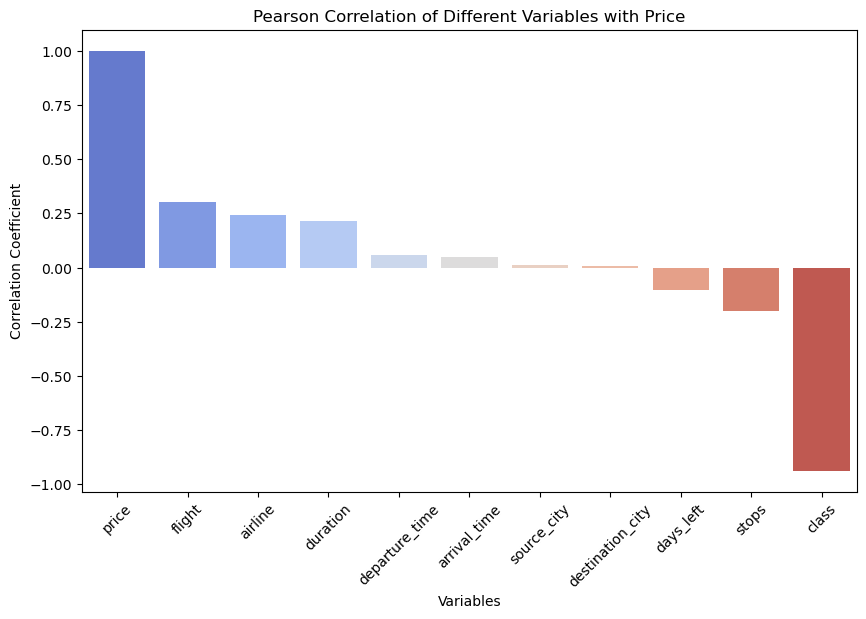

In [407]:
# Initialize Label Encoder
label_encoder = LabelEncoder()

# Copying the original data to avoid modifying it directly
encoded_data = df.copy()

# Encode object-type columns
for column in encoded_data.columns:
    if encoded_data[column].dtype == 'object':
        encoded_data[column] = label_encoder.fit_transform(encoded_data[column])

# Calculate the Pearson correlation of the "price" column with other variables
price_correlation = encoded_data.corr()['price'].sort_values(ascending=False)

# Set up the matplotlib figure for the bar chart
plt.figure(figsize=(10, 6))

# Plotting the correlation values
sns.barplot(x=price_correlation.index, y=price_correlation.values, palette="coolwarm")

# Improve plot aesthetics
plt.xticks(rotation=45)
plt.title("Pearson Correlation of Different Variables with Price")
plt.ylabel("Correlation Coefficient")
plt.xlabel("Variables")

# Show the plot
plt.show()

The analysis revealed key insights into how various factors are correlated with flight prices. Key findings include:

* A strong negative correlation with flight `class`, indicating that certain classes (likely economy) tend to be cheaper.
* Moderate positive correlations with `flight` and `airline`, suggesting these factors may influence pricing to some extent.
* Weak positive correlations with `duration`, `departure time`, and `arrival time`, showing these factors have minimal impact on price.
* Very weak or no correlations with `source_city` and `destination city`, and `days left` before the flight, implying these factors do not significantly affect flight prices.

These results are crucial for understanding the elements most influential in determining flight prices, which can be particularly valuable for pricing strategy analysis in the airline industry.

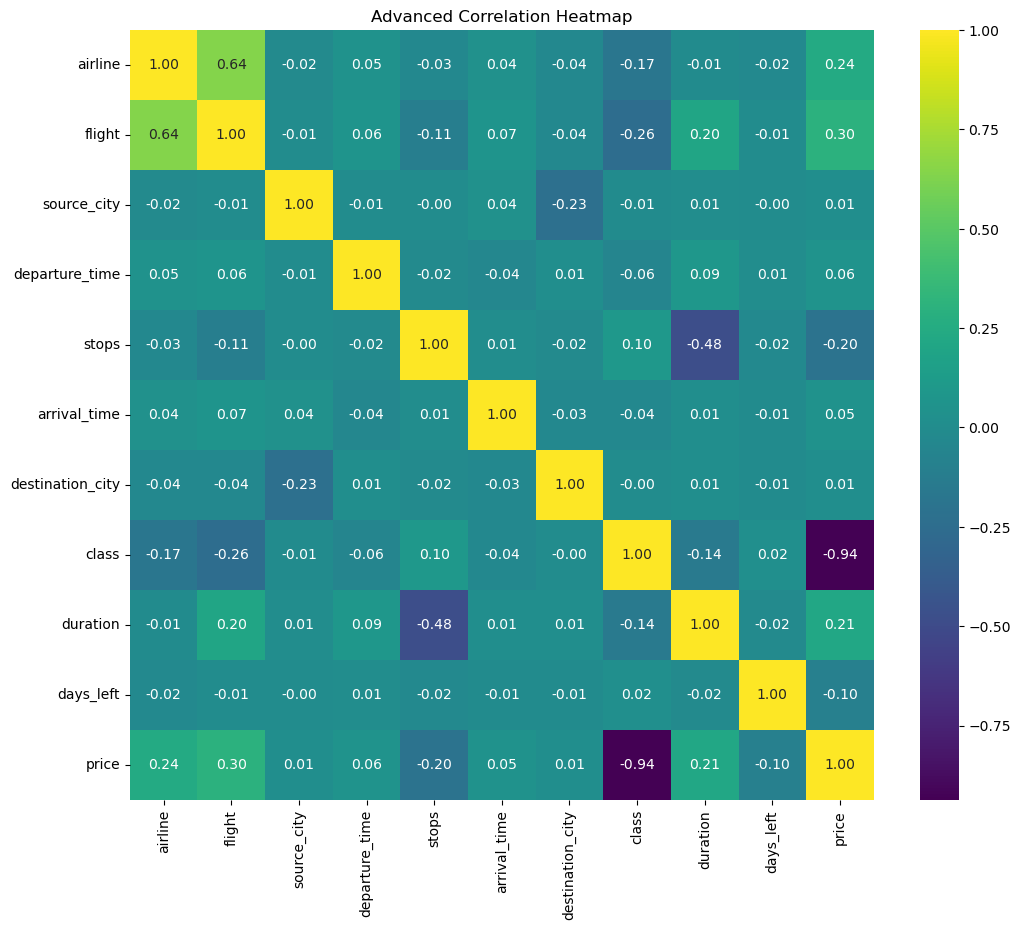

In [408]:
plt.figure(figsize=(12, 10))
sns.heatmap(encoded_data.corr(), annot=True, fmt=".2f", cmap='viridis')
plt.title("Advanced Correlation Heatmap")
plt.show()

In [409]:
#drop useless columns
df.drop(['source_city', 'destination_city'], axis=1, inplace=True)

## Visualition 

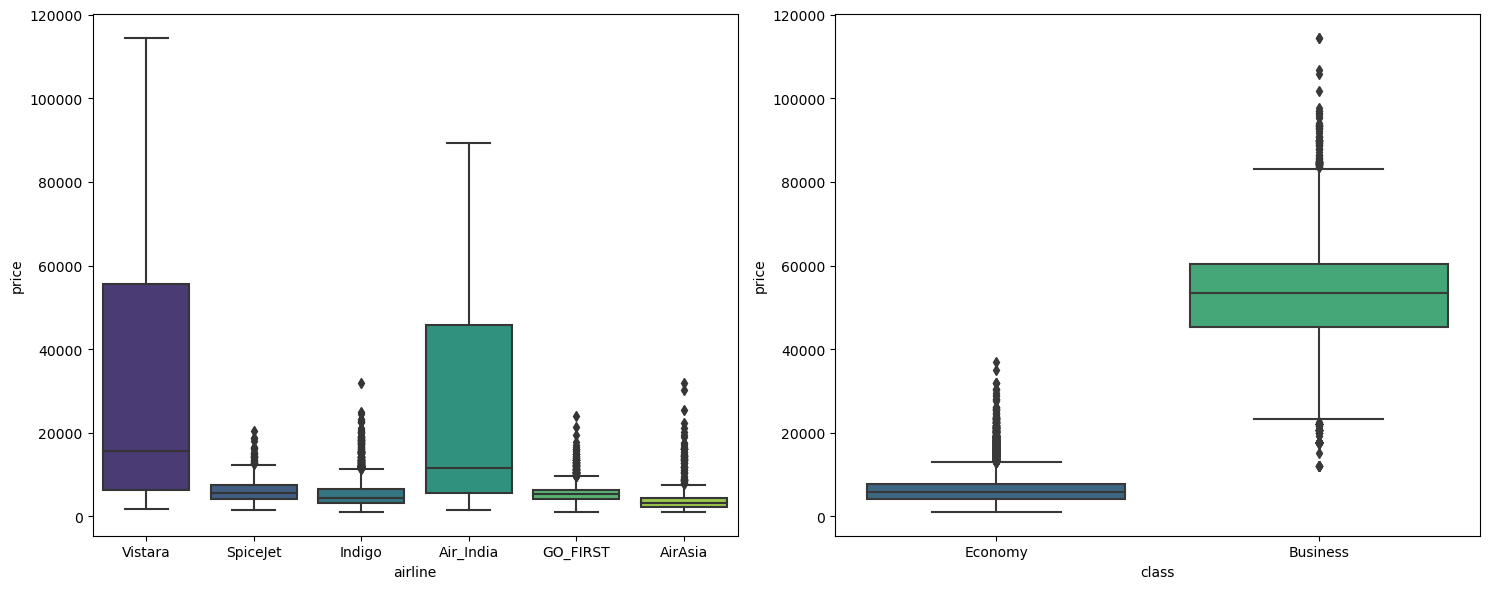

In [410]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.boxplot(ax=axes[0], x='airline', y='price', data=df, palette='viridis')
sns.boxplot(ax=axes[1], x='class', y='price', data=df, palette='viridis')
plt.tight_layout()
plt.show()

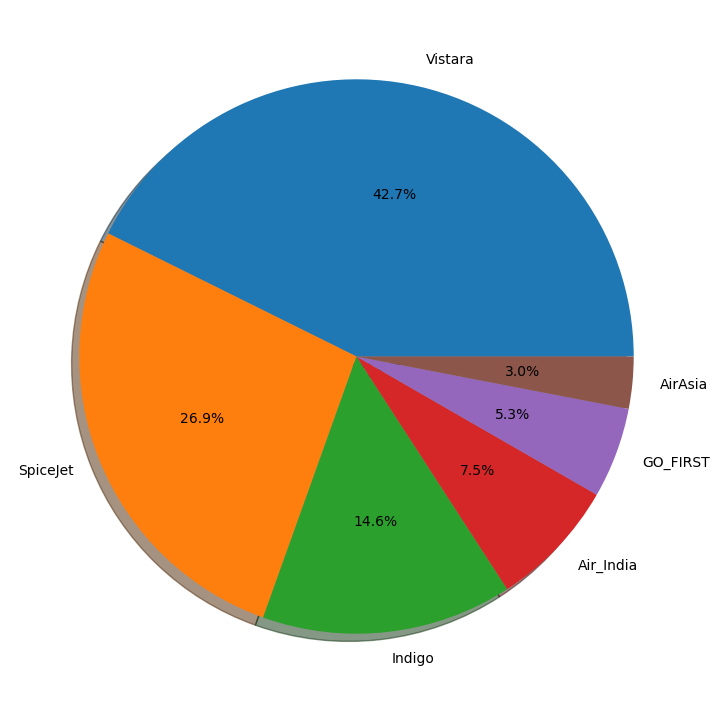

In [411]:
plt.figure(figsize=(16,9))
labels = list(df['airline'].unique())
values = list(df['airline'].value_counts())
plt.pie(values, labels = labels, autopct='%1.1f%%',shadow=True )
plt.show()

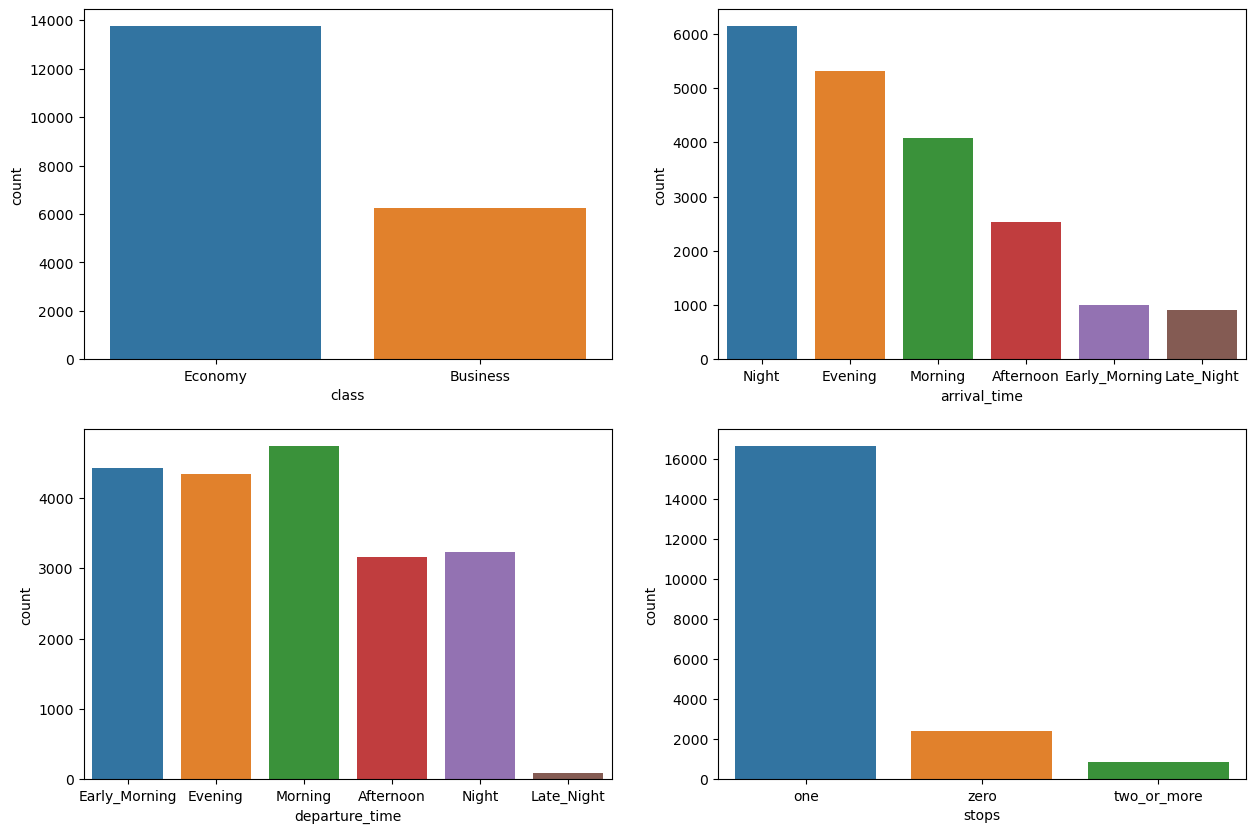

In [412]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))
sns.countplot(ax=ax[0,0],data = df,  x='class')
sns.countplot(ax=ax[0,1],data= df,  x='arrival_time')
sns.countplot(ax=ax[1,0],data = df,  x='departure_time')
sns.countplot(ax=ax[1,1],data = df,  x='stops')
plt.show()

### Separating Dataframe

In [413]:
#Stratified Shuffle Split
from sklearn.model_selection import StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in stratified_split.split(df, df['class']):
  df_train = df.loc[train_index]
  df_test = df.loc[test_index]

The following Python code demonstrates how to split a dataset into training and testing sets using the `StratifiedShuffleSplit` method from `sklearn.model_selection`. This method ensures that both sets maintain the same proportion of classes as the original dataset, which is particularly useful for datasets with imbalanced classes.

<AxesSubplot:xlabel='class', ylabel='count'>

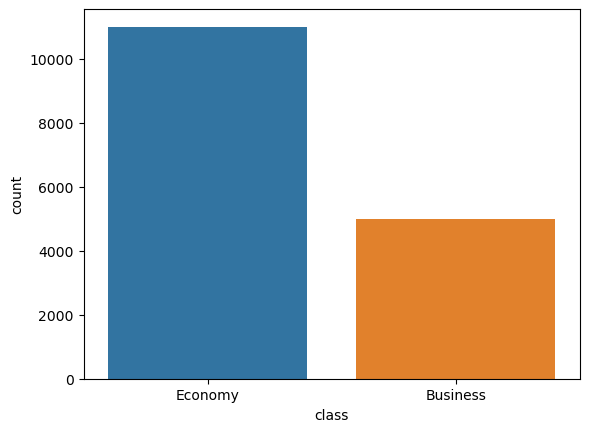

In [414]:
sns.countplot(data = df_train,  x='class')

In [415]:
#Numeric & catigorical
# Dropping the target variable 'price' to isolate the features
x_train = df_train.drop('price', axis=1)

# Selecting numeric features explicitly
x_num = df_train[['duration', 'days_left']]

# Isolating the target variable 'price' for training
y_train = df_train['price'].copy()

### Pipeline

In [416]:
#Creating numeric pipeline
#When preparing numeric data for machine learning models, standardization is a common preprocessing step. This involves scaling numeric features to have a mean of 0 and a standard deviation of 1. The `Pipeline` class from Scikit-learn allows us to streamline this process. Below is an example of creating a numeric pipeline with a standard scaler:
num_pipeline = Pipeline([
                         ('std_scaler', StandardScaler())
])

### Useful Resources:

- **Scikit-learn Pipeline Documentation**: Learn more about how the `Pipeline` class can simplify the process of transforming your data. [Read more here](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
- **StandardScaler Documentation**: Dive deeper into the `StandardScaler` to understand how it standardizes features. [Explore here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
- **Preprocessing Data with Scikit-learn**: Explore more about preprocessing techniques available in Scikit-learn, including scaling, normalization, and more. [Learn more](https://scikit-learn.org/stable/modules/preprocessing.html).


In [432]:
#Creating full pipeline

nums = list(x_num)

cats = ['airline', 'departure_time', 'stops', 'arrival_time','class']

full_pipeline = ColumnTransformer([
                                   ('numeric', num_pipeline, nums),
                                   ('1_encoder', OneHotEncoder(), cats)
])

In [418]:
#Preparing trainn data for ML
x_prepared = full_pipeline.fit_transform(x_train)

In [419]:
#Separating test data

y_test = df_test['price'].copy()

x_test = df_test.drop('price', axis=1)

#Preparing test data for ML
test_prepared = full_pipeline.fit_transform(x_test)

# Machine Leaning

### Linear Regression

### Useful Links:

- **ColumnTransformer Documentation**: Get a deeper understanding of how `ColumnTransformer` works and how it can be used to apply different preprocessing for different types of data. [Read more here](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html).
- **Linear Regression in Scikit-learn**: Explore the `LinearRegression` class, understanding its parameters, and how it can be used for predicting continuous values. [Explore here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).
- **Preprocessing and Feature Extraction**: Learn about different preprocessing techniques and how to extract features from your dataset effectively. [Learn more](https://scikit-learn.org/stable/modules/preprocessing.html).


In [420]:
# Define 'x_prepared' variable
x_prepared = full_pipeline.fit_transform(x_train)

# Teaching model 
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(x_prepared, y_train)

LinearRegression()

In [421]:
#Predicting

y_predicted = LR_model.predict(test_prepared)

#Calculating MAE and RMSE
mae = mean_absolute_error(y_predicted, y_test)
mse = mean_squared_error(y_predicted, y_test)

#Showing
print(f'Mean absolute error = {np.around(mae)}')
print(f'Root mean squarred error = {np.around(np.sqrt(mse))}')

Mean absolute error = 4634.0
Root mean squarred error = 6852.0


### Decision Tree Regressor

In [422]:
DT_model = DecisionTreeRegressor()

DT_model.fit(x_prepared,y_train)

DT_predicted = DT_model.predict(test_prepared)

#Calculating MAE and RMSE
DT_mae = mean_absolute_error(DT_predicted, y_test)
DT_mse = mean_squared_error(DT_predicted, y_test)

#Showing
print(f'Mean absolute error = {np.around(DT_mae)}')
print(f'Root mean squarred error = {np.around(np.sqrt(DT_mse))}')

Mean absolute error = 3912.0
Root mean squarred error = 6854.0


### Support Vector Machine

In [423]:
from sklearn.svm import SVR

SVR_model = SVR()

SVR_model.fit(x_prepared, y_train)

SVR_predicted = SVR_model.predict(test_prepared)
 
#Calculating MAE and RMSE
SVR_mae = mean_absolute_error(SVR_predicted, y_test)
SVR_mse = mean_squared_error(SVR_predicted, y_test)

#Showing
print(f'Mean absolute error = {np.around(SVR_mae)}')
print(f'Root mean squarred error = {np.around(np.sqrt(SVR_mse))}')

Mean absolute error = 15817.0
Root mean squarred error = 25946.0


# Submission

In [424]:
df_s = pd.read_csv("https://raw.githubusercontent.com/Ozodiy/Aviaticket_price_predictor/main/train_data.csv")
df_s.drop('flight', axis=1, inplace=True)
df_s.head()

,id,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,1,Vistara,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
1,2,SpiceJet,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
2,3,Vistara,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
3,4,Vistara,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
4,5,Indigo,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


In [425]:
xsub_prepared = full_pipeline.fit_transform(df_s)

According to the results of 'mean_absolute_error' and 'mean_squarred_error', I chose Random forest regressor as a model.

In [426]:
from sklearn.ensemble import RandomForestRegressor
RF_model = RandomForestRegressor()
RF_model.fit(x_prepared, y_train)


RandomForestRegressor()

In [427]:
sample_s = pd.read_csv("https://raw.githubusercontent.com/Ozodiy/Aviaticket_price_predictor/main/sample_solution.csv")
sample_s.head(12)

,id,price
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [428]:
y_sub = RF_model.predict(xsub_prepared)
sample_s['price'] = y_sub[:len(sample_s)]
sample_s.to_csv('submission.csv', index=False)

In [429]:
pd.read_csv("./submission.csv")

,id,price
0,1,6589.9000
1,2,5535.0800
2,3,66342.8500
3,4,5705.8150
4,5,9793.6325
...,...,...
4995,4996,8514.2500
4996,4997,26760.7200
4997,4998,2704.7200
4998,4999,6915.3600
